<a href="https://colab.research.google.com/github/aditya2kahol/wandb-model-dev-course/blob/main/Course-Project/W%26B_CP_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W&B Course-Project: Image Fusion
## Baseline model
### A self supervised learning technique for multi-focus image fusion.

<tt>Prepared by: Aditya Kahol</tt>

- What is image fusion? > [click here](https://en.wikipedia.org/wiki/Image_fusion)

- What is multi-focus image fusion? > [click here](https://en.wikipedia.org/wiki/Multi-focus_image_fusion)

<b>Caution: </b>
1. This notebook is for the baseline model, and hence the results are not of importance, my intension is to understand and gather insights from what I've done so far.
2. The project is still under experiment stage, refer to the next notebook (if provided) for better results.

In [1]:
#import necessary libraries
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.transforms as T
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder

In [2]:
#install wandb
!pip install wandb --upgrade --quiet

     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 147 kB 70.7 MB/s 
     |████████████████████████████████| 181 kB 67.5 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 


In [3]:
#import wandb
import wandb

In [4]:
#login
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
#set project name
PROJECT_NAME = "W&B Course-Project Image-Fusion"
ENTITY = None

Now Download the dataset and save the zip file as a wandb artifact.

In [6]:
%%capture
!wget https://github.com/aditya2kahol/wandb-model-dev-course/raw/main/Course-Project/input.zip
!unzip /content/input.zip

In [9]:
with wandb.init(project = PROJECT_NAME, entity = ENTITY, job_type = "upload"):
  #create an artifact for all the raw data
  artifact_name = 'mfif-dataset-zip'
  artifact = wandb.Artifact(artifact_name, type='dataset')

  # Add a file to the artifact's contents
  artifact.add_file('input.zip')

  # Save the artifact version to W&B and mark it as the output of this run
  wandb.log_artifact(artifact)

wandb: Currently logged in as: adi001. Use `wandb login --relogin` to force relogin


Now let's prepare the dataset for training

In [86]:
#set seeds for reproducibilty
def set_deterministic(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False

    torch.set_default_dtype(torch.float32)

    return "Done"

SEED = 1234 # any number 
set_deterministic(seed = SEED)

'Done'

In [87]:
filename = 'input'

In [88]:
#print number of training image pairs
print(len(os.listdir(filename)))

63


In [89]:
#parse image paths
def parse(index, filename):
    """
        PATHS: type -> List
    """
    i = 0 #starting index for search
    PATHS = [] #this list will contain the image names
    Found = False #flag used to terminate the code
    
    for file in os.listdir(filename):
        for image_name in os.listdir(filename + '/' + file):
            
            if i == index:
                Found = True
                PATHS.append(filename + '/' + file + '/' + image_name)
                
        if Found == True:
            break
            
        i += 1
        
    return PATHS

In [90]:
#create a custom dataset which will output the image pairs for fusion
class custom_dataset(Dataset):
    def __init__(self, filename, transform = None):
        super().__init__()
        self.filename = filename
        self.length = len(os.listdir(filename))
        self.transform = transform
    
    def __len__(self):
        return self.length
    
    def __getitem__(self,idx):
        
        if idx >= self.length:
            print("You exceeded the count!")
            return None

        image_paths = parse(idx, self.filename)
        
        Images = [] #List to contain images.
        
        for path in image_paths:
            if self.transform:
                Images.append(self.transform(Image.open(path)))
            else:
                Images.append(Image.open(path))
        
        return tuple(Images)

In [91]:
#Define the transforms
transforms = T.Compose([T.CenterCrop(size = (350,400)),
                        #cropping because the images are of unequal sizes and we need to retain the aspect ratio. 
                        T.ToTensor()])

In [92]:
#create dataset
dataset = custom_dataset(filename, 
                         transform = transforms)
len(dataset)

63

In [93]:
#check shape of the image pairs
img1, img2 = dataset[10]
img1.shape, img2.shape

(torch.Size([3, 350, 400]), torch.Size([3, 350, 400]))

In [94]:
#define utility function to view images from the dataset
def view_image(ds):
    plt.figure(figsize = (10,10))
    plt.subplot(121)
    plt.imshow(ds[0].permute(1,2,0))
    plt.title("Image 1")
    plt.axis("off")
    plt.subplot(122)
    plt.imshow(ds[1].permute(1,2,0))
    plt.title("Image 2")
    plt.axis("off")
    plt.show()

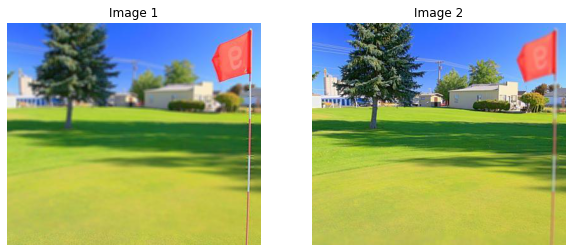

In [95]:
view_image(dataset[14])

Let's create a wandb Image Table for our report and EDA

In [72]:
def make_row(img1, img2):
  """
    function to create and return wandb images
  """
  return [wandb.Image(img1.permute(1,2,0).numpy()), 
          wandb.Image(img2.permute(1,2,0).numpy())]

#check make_row func
make_row(*dataset[0])

In [23]:
#Log the first 20 dataset images as a Table
num_images = 20

with wandb.init(project=PROJECT_NAME, entity=ENTITY, job_type="EDA") as run:    
  df = pd.DataFrame(data=[make_row(*dataset[i]) for i in range(num_images)],
                    columns='Mutli-Focus Image1,Multi-Focus Image2'.split(','))
  run.log({'Images-2-Fuse': wandb.Table(dataframe=df)})

Create training and validation splits

In [73]:
val_size = int(0.06 * len(dataset))
train_size = len(dataset) - val_size

#train-validation split
train_ds, val_ds = random_split(dataset, [train_size, val_size])

len(train_ds), len(val_ds)

(60, 3)

Create dataloaders with whole dataset as the batch-size (since only 57 image pairs are used for training)

In [102]:
train_dl = DataLoader(dataset = train_ds,
                     batch_size = 20,
                     shuffle = False,
                      num_workers = 2,
                      pin_memory = True)

val_dl = DataLoader(dataset = val_ds,
                   batch_size = len(val_ds),
                   shuffle = False,
                    num_workers = 2,
                    pin_memory = True)

In [103]:
for img1, img2 in train_dl:
    print(img1.shape)
    break

torch.Size([20, 3, 350, 400])


## Create Baseline model architecture

<tt>About Convolutions and Deconvolutions.</tt>

`syntax for convolution:`
```
nn.Conv2d(in_channels, out_channels, kernel_size, padding, stride)
# out = (n-k+2p)/s + 1 (where n is the image height/width)
```
`syntax for deconvolution`

```
nn.ConvTranspose2d(in_channels, out_channels, kernel_size, padding, stride)
#out = s(n-1) + k - 2p (where n is the image height/width)
```

<b>Model Information</b>

- A Siamese kind of Autoencoder based architecture is considered for the baseline model, having skip connections between encoder and decoder.

- At first, two source images will be passed through the encoder in a siamese fashion, which will output two feature vectors say A and B of size 500 each

- We then stack them together horizontally, and pass it to the decoder.

- The decoder then outputs an image matrix of the same size as the input source images.

- The final step is to calculate the loss in a self supervised fashion.

- Let's say, the output to the decoder is `F` and the source images were `I1` and `I2`. For the baseline model, we have created a custom MSE loss function which calculates the loss like this:
  - $ Mean({(F - I_1)}^2 + {(F - I_2)}^2)$

Now have a look at the code and results

<b>What is expected from this model: </b>

- Automatically capture the focus regions of each of the source images and put those features together and create a fused image.
- Capture the color and contrast information of both the source images.
- Make sure no additional artifacts are generated (noise, blurriness, etc).

In [104]:
#model construction
def convblock(in_channels, out_channels, pool = None):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1),
             nn.BatchNorm2d(out_channels),
             nn.ReLU(inplace = True)]
    if pool:
        layers.append(nn.MaxPool2d(pool))
    return nn.Sequential(*layers)

class Fusion(nn.Module):
    """
        Exp: Encoder-Decoder architecture with skip connections.
    """
    def __init__(self):
        super().__init__()
        #in: 3,350,400
        
        self.encoder_part1 = nn.Sequential(nn.Conv2d(3, 32, kernel_size = 5, padding = 2),
                                          nn.BatchNorm2d(32),
                                          nn.ReLU(),
                                          nn.MaxPool2d(2), #out: 32,175,200
                                          nn.Conv2d(32,64,kernel_size = 3, padding = 1),
                                          nn.BatchNorm2d(64),
                                          nn.ReLU()
                                         )
        self.res = nn.Sequential(convblock(64,64),convblock(64,64,pool = 5)) #out: 64,35,40
                                          
        self.encoder_part2 = nn.Sequential(nn.Conv2d(64,128,kernel_size = 3, padding = 1),
                                           nn.BatchNorm2d(128),
                                           nn.ReLU(),
                                           nn.MaxPool2d(5), #out: 128,7,8
                                           nn.Flatten(), #out: 128*7*8
                                           nn.Linear(128*7*8,500) #out: 500,
                                          )

        self.linear = nn.Linear(1000,128*7*8) #out: 128*7*8,
        
        #now change the view of this to 128,7,8
        
        self.decoder_part1 = nn.Sequential(nn.ConvTranspose2d(128, 64, stride = 5, kernel_size = (7,7), padding = 1),
                                           #out: 64,35,40
                                           nn.ReLU()
                                          )
        self.decoder_part2 = nn.Sequential(nn.ConvTranspose2d(64, 32, stride = 5, kernel_size = (7,7), padding = 1),
                                           #out: 32,175,200
                                           nn.ReLU(),
                                           nn.ConvTranspose2d(32, 3, stride = 2, kernel_size = (4,4), padding = 1)
                                           #out: 3,350,400
                                          )
    
    def forward(self, img1, img2):
        """
            img1 -> 3,350,400
            img2 -> 3,350,400
        """                                         
        #encode image1
        out1 = self.encoder_part1(img1)
        res1 = self.res(out1)
        out1 = self.encoder_part2(res1) #out: 500

        #encode image2
        out2 = self.encoder_part1(img2)
        res2 = self.res(out2)
        out2 = self.encoder_part2(res2) #out: 500                                   
        
        #concat the encoded images.
        fused_out = torch.hstack([out1,out2]) #out: 1000
        
        #bottle-neck
        fused_out = self.linear(fused_out) #out: 128*7*8
        
        #reshape to 128,5,6
        fused_out = fused_out.view(-1,128,7,8) #out: 128,7,8
        
        #decode fused image
        fused_out = self.decoder_part1(fused_out) #out: 64,35,40 
        fused_out = fused_out + res1 + res2 #skip connection
        fused_out = self.decoder_part2(fused_out) #out: 3,350,400
        
        return fused_out

In [105]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [106]:
#initialize model
model = Fusion()

#set model to device
model = model.to(device)

#display model arch.
model

Fusion(
  (encoder_part1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
  )
  (res): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=5, stride=5, pad

In [107]:
#initialize baseline hyperparameters
epochs = 70
learning_rate = 0.0001
weight_decay = 1e-4
optimizer = optim.Adam(model.parameters(), 
                       lr = learning_rate,
                       weight_decay = weight_decay)
grad_clip = 0.9
batch_size = len(train_ds)/3

In [108]:
#define the custom MSE loss function
class custom_MSE(nn.Module):
    def __init__(self):
        super(custom_MSE, self).__init__();

    def forward(self, prediction, targets):
        target1, target2 = targets
        square_difference = torch.square(prediction - target1) + torch.square(prediction - target2)
        loss_value = torch.mean(square_difference)
        return loss_value

In [109]:
criterion = custom_MSE()

In [110]:
config_dict = dict(
    epochs = epochs,
    lr = learning_rate,
    batch_size = batch_size,
    weight_decay = weight_decay,
    grad_clip = grad_clip,
    Loss = "custom-mse",
    optimizer = "adam"
)

In [111]:
config_dict

{'Loss': 'custom-mse',
 'batch_size': 20.0,
 'epochs': 70,
 'grad_clip': 0.9,
 'lr': 0.0001,
 'optimizer': 'adam',
 'weight_decay': 0.0001}

In [112]:
#define training pipeline.
def fit(config_dict, grad_clip = None):
  train_losses = []
  val_losses = []
  with wandb.init(project = PROJECT_NAME, entity = ENTITY, config = config_dict) as run:
    run.watch(model)
    torch.cuda.empty_cache()
    for epoch in range(epochs):
      T_loss = 0
      V_loss = 0
      model.train()
      for img1, img2 in train_dl:
        #set images to device
        img1 = img1.to(device)
        img2 = img2.to(device)
        #forward pass
        fused = model(img1, img2)
        
        #calculate loss
        loss = criterion(fused, (img1, img2))
        
        #backward pass
        loss.backward()
        
        # Gradient clipping
        if grad_clip: 
            nn.utils.clip_grad_value_(model.parameters(), grad_clip)
        
        #weight update step
        optimizer.step()
        
        #set zero grad
        optimizer.zero_grad()
        
        #loss collect
        train_losses.append(loss.item())
        
        T_loss += loss.item()
        
      model.eval()
      for img1, img2 in val_dl:
        img1 = img1.to(device)
        img2 = img2.to(device)
        fused = model(img1, img2) #forward pass
        loss = criterion(fused, (img1, img2))#loss eval
        val_losses.append(loss.item()) #loss collect
        V_loss += loss.item()
        
      run.log({"Epoch": epoch, 
                  "Train-Loss": T_loss/len(train_dl),
                  "Val-loss": V_loss/len(val_dl)}
                )
      print(f"Epoch {epoch}: Train-Loss = {T_loss/len(train_dl):.4f}, Val-loss = {V_loss/len(val_dl):.4f}")
        
  return dict(train_loss = train_losses, val_loss = val_losses)

In [113]:
#train the model
torch.cuda.empty_cache()
history = fit(config_dict, grad_clip = grad_clip)

Epoch 0: Train-Loss = 0.8005, Val-loss = 0.6321
Epoch 1: Train-Loss = 0.6478, Val-loss = 0.6160
Epoch 2: Train-Loss = 0.5515, Val-loss = 0.5805
Epoch 3: Train-Loss = 0.4806, Val-loss = 0.5213
Epoch 4: Train-Loss = 0.4200, Val-loss = 0.4429
Epoch 5: Train-Loss = 0.3639, Val-loss = 0.3565
Epoch 6: Train-Loss = 0.3122, Val-loss = 0.2786
Epoch 7: Train-Loss = 0.2700, Val-loss = 0.2312
Epoch 8: Train-Loss = 0.2309, Val-loss = 0.1992
Epoch 9: Train-Loss = 0.1976, Val-loss = 0.1745
Epoch 10: Train-Loss = 0.1716, Val-loss = 0.1584
Epoch 11: Train-Loss = 0.1495, Val-loss = 0.1437
Epoch 12: Train-Loss = 0.1303, Val-loss = 0.1205
Epoch 13: Train-Loss = 0.1154, Val-loss = 0.1041
Epoch 14: Train-Loss = 0.1035, Val-loss = 0.0932
Epoch 15: Train-Loss = 0.0931, Val-loss = 0.0817
Epoch 16: Train-Loss = 0.0843, Val-loss = 0.0726
Epoch 17: Train-Loss = 0.0774, Val-loss = 0.0667
Epoch 18: Train-Loss = 0.0714, Val-loss = 0.0613
Epoch 19: Train-Loss = 0.0663, Val-loss = 0.0565
Epoch 20: Train-Loss = 0.0623,

Epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
Train-Loss,█▇▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Val-loss,██▇▅▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch,69
Train-Loss,0.02955
Val-loss,0.02702


In [ ]:
#plot losses and accuracies
plt.plot(history['train_loss'])
plt.plot(history['val_loss'])
plt.train("Losses")

In [119]:
#try fusing the images now.
@torch.no_grad()
def fuse_and_display(model,ds):
  img1, img2 = ds
  I1 = img1.unsqueeze(0).to(device)
  I2 = img2.unsqueeze(0).to(device)

  fused = model(I1, I2)
  fused = fused.squeeze(0).detach().cpu()

  plt.figure(figsize = (20,15))
  plt.subplot(131)
  plt.imshow(img1.permute(1,2,0))
  plt.title("Source Image 1")
  plt.axis("off")
  plt.subplot(132)
  plt.imshow(img2.permute(1,2,0))
  plt.title("Source Image 2")
  plt.axis("off")
  plt.subplot(133)
  plt.imshow(fused.permute(1,2,0))
  plt.title("Fused image")
  plt.axis("off")
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


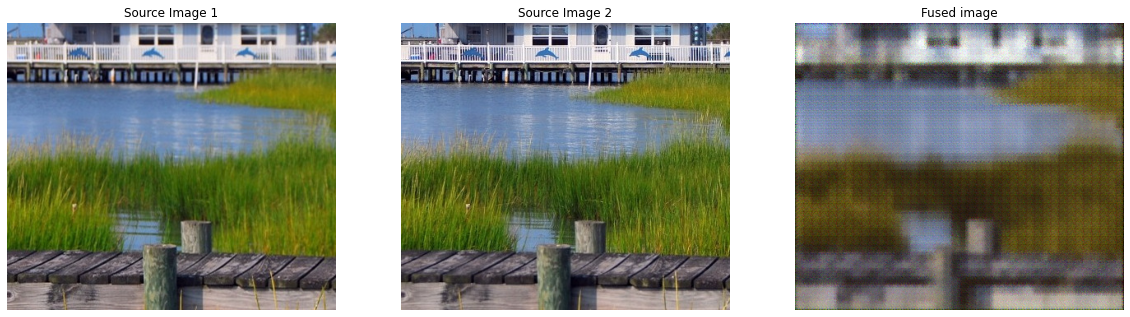

In [122]:
fuse_and_display(model,val_ds[2])

1. <b>Criticism</b>
- As can be seen, the model is not able to capture the following things:
  - Color information
  - Focus regions
    - <b>Basically everything that we want !!</b>
- Even if we increase the number of epochs, this model wont be getting any better.

2. <b>Technical</b>
- This model is actually capturing the non focus parts of the image, and the most probable reason for this is the `loss` function that we are using. That is a simple `MSE` loss will not work.

3. <b>Positive points</b>
- The model is able to construct similar looking images (when compared to their sources), hence we are at the right track, maybe a minor tweaking to the model architecture will help. Changing the loss function would certainly make things better, we just need to make sure that the loss function penalizes the unfocused parts of the output image.

Now lets log this information as a wandb table.

In [129]:
def make_new_rows(model, img1, img2):
  I1 = img1.unsqueeze(0).to(device)
  I2 = img2.unsqueeze(0).to(device)

  fused = model(I1, I2)
  fused = fused.squeeze(0).detach().cpu()

  return [wandb.Image(img1.permute(1,2,0).numpy()), 
          wandb.Image(img2.permute(1,2,0).numpy()),
          wandb.Image(fused.permute(1,2,0).numpy())]

#check function output
make_new_rows(model, *val_ds[0])

In [128]:
#Log the validation set images in a table

with wandb.init(project=PROJECT_NAME, entity=ENTITY, job_type="EDA") as run:    
  df = pd.DataFrame(data=[make_new_rows(model,*val_ds[i]) for i in range(len(val_ds))],
                    columns='Source-image1,Source-image2,Fused-image'.split(','))
  run.log({'Images-Fused-Baseline': wandb.Table(dataframe=df)})